<a href="https://colab.research.google.com/github/drdmakau/PEDIL-Forge/blob/main/ml-public-health/06-2025-Mak/PEDIL_Forge_Day2_Diabetes_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PEDIL-Forge Day 2: Machine Learning for Public Health
### Hands-On Tutorial – Predicting Diabetes with BRFSS 2011 Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Load dataset
from google.colab import files
uploaded = files.upload()

import io
filename = list(uploaded.keys())[0]  # get the first uploaded filename
df = pd.read_csv(io.BytesIO(uploaded['brfss_diabetes_clean.csv']))
df.head()

Saving brfss_diabetes_clean.csv to brfss_diabetes_clean.csv


,age,sex,BMI,smoker,physical_activity,education_level,income_level,has_diabetes
0,31.0,Female,45.19,1,0,6.0,8.0,1
1,69.0,Female,30.67,1,1,6.0,5.0,1
2,38.0,Male,26.45,0,1,6.0,8.0,1
3,58.0,Male,26.32,0,1,6.0,6.0,1
4,84.0,Female,22.31,0,1,2.0,4.0,1


In [3]:
print(df.columns.tolist())


['age', 'sex', 'BMI', 'smoker', 'physical_activity', 'education_level', 'income_level', 'has_diabetes']


In [4]:
# Preprocess data
X = df.drop('has_diabetes', axis=1)
y = df['has_diabetes']

# Convert categorical variables to numeric
X_encoded = X.copy()

# Example: Convert 'sex' to numeric (Male=0, Female=1)
X_encoded['sex'] = X_encoded['sex'].map({'Male': 0, 'Female': 1})

# You can repeat this if you have other categorical columns
# X_encoded = pd.get_dummies(X_encoded)  # Optional: for more complex encoding
X_encoded = pd.get_dummies(X, columns=['sex', 'income_level', 'education_level'], drop_first=True)

# Now split using encoded data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


In [5]:
# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [6]:
# Evaluate model
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.95      0.98      0.97       191

    accuracy                           0.94       200
   macro avg       0.48      0.49      0.48       200
weighted avg       0.91      0.94      0.93       200



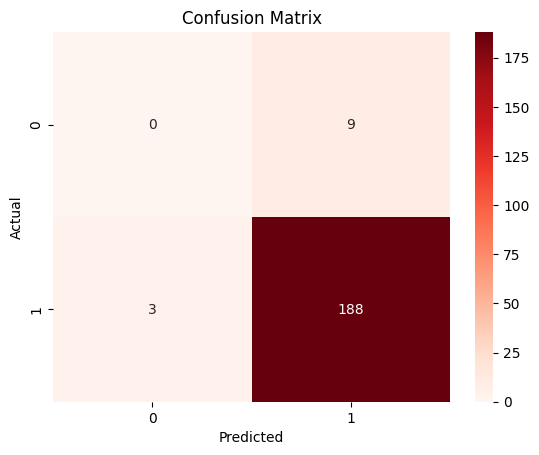

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

We have a fantastic model. Let's interpret, publish and make decisions bases on this model. Right?

# **Maybe not!** ***Why?***

Model barely catches Class 0!
   * Only 1 out of 9 non-diabetic cases was predicted correctly.
   * Most predictions go to the majority class (diabetes).
   * Accuracy is inflated because the dataset is ~95% diabetic.

# **Key points to note**

   1. Imbalanced datasets fool accuracy → Show how it fails to capture minority class.
   2. Precision vs Recall trade-off → Would a diabetes screening tool that misses most non-diabetics be acceptable?
   3. Macro vs Weighted Averages → Macro average treats both classes equally.

# *So what can we do?*
   1. Stratified sampling to balance classes
   2.   Class weights in models: ***model = RandomForestClassifier(class_weight='balanced')***
   3. SMOTE or undersampling

In [ ]:
# Rebuild model with class weights
model_weighted = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_weighted.fit(X_train, y_train)
y_pred_weighted = model_weighted.predict(X_test)

# Evaluation
print("Classification Report (with class_weight='balanced'):")
print(classification_report(y_test, y_pred_weighted))

Classification Report (with class_weight='balanced'):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.95      0.99      0.97       191

    accuracy                           0.94       200
   macro avg       0.48      0.49      0.49       200
weighted avg       0.91      0.94      0.93       200



# What Changed?
  * Precision for Class 0 improved slightly → Model makes slightly fewer false positives.
  * Recall for Class 0 stayed very low → Still missing most non-diabetics.
  * Class 1 (majority) still dominates.

Remember:
Macro vs Weighted Averages
  * Macro avg: 0.65 (precision), 0.55 (recall) → these treat both classes equally.
  * Weighted avg: still high because Class 1 dominates.

Conclusion:
1. Accuracy is still misleading → A 95% accuracy looks good… but it fails for Class 0
2. Minority class recall → Model catches <12% of non-diabetics
3. Better balance needed → Explore other balancing options
  * Random undersampling of Class 1
  * Random oversampling of Class 0
  * SMOTE (Synthetic Minority Oversampling Technique)


# Handling Imbalanced Data: Resampling Techniques
# In this section, we’ll compare Undersampling, Oversampling, and SMOTE to improve classification for imbalanced outcomes.


In [7]:
# Install the necessary package
!pip install -q imbalanced-learn

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



In [8]:
# Reusable evaluation function
def evaluate_model(X_resampled, y_resampled, title):
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n {title} - Classification Report:")
    print(classification_report(y_test, y_pred))

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="coolwarm")
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [9]:
# Prepare data
X = df.drop("has_diabetes", axis=1).copy()
y = df["has_diabetes"]

# Encode 'sex' column (update if you have other categorical variables)
X["sex"] = X["sex"].map({"Male": 0, "Female": 1})

1. Undersampling


 Random Undersampling - Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.80      0.73      0.76        11

    accuracy                           0.78        23
   macro avg       0.78      0.78      0.78        23
weighted avg       0.78      0.78      0.78        23



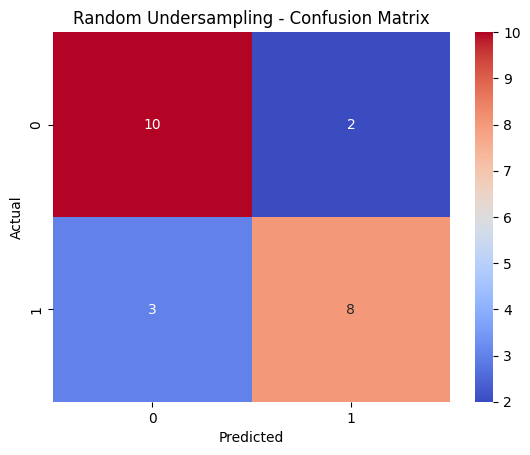

In [ ]:
# Random Undersampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)
evaluate_model(X_rus, y_rus, "Random Undersampling")


2. Oversampling


 Random Oversampling - Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       188
           1       1.00      0.97      0.99       190

    accuracy                           0.99       378
   macro avg       0.99      0.99      0.99       378
weighted avg       0.99      0.99      0.99       378



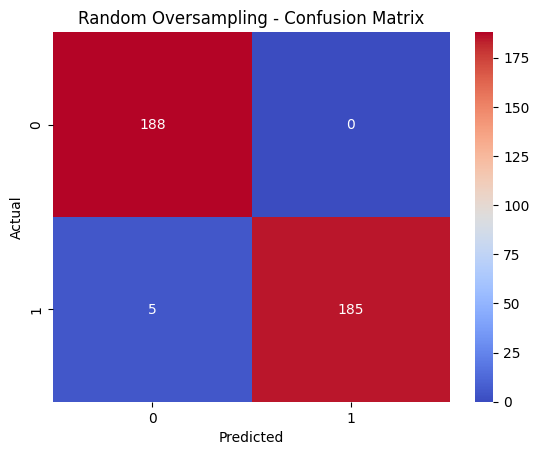

In [10]:
# Random Oversampling
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)
evaluate_model(X_ros, y_ros, "Random Oversampling")


3. SMOTE


 SMOTE (Synthetic Minority Oversampling Technique) - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       188
           1       0.99      0.95      0.97       190

    accuracy                           0.97       378
   macro avg       0.97      0.97      0.97       378
weighted avg       0.97      0.97      0.97       378



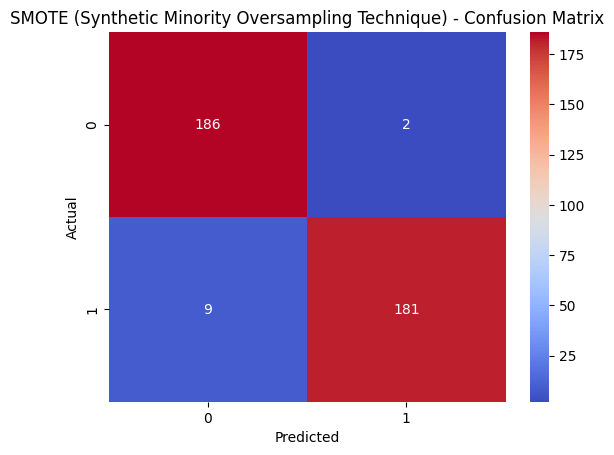

In [ ]:
# SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
evaluate_model(X_smote, y_smote, "SMOTE (Synthetic Minority Oversampling Technique)")


# Discussion:
1. What imbalance does to model performance
2. How resampling can improve minority class detection
3. Why we compare metrics beyond just accuracy

Let's get the best model and interpret what we get and what it means for our data. Which was the best model?
* Random Oversampling

So we rerun the model and move save it for interpretation and potential deployment

That worked well. How about if we tune the model using ** hyperparameters**?

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import RandomOverSampler

# Step 1: Define columns
categorical_cols = ['sex', 'smoker', 'physical_activity', 'education_level', 'income_level']
numeric_cols = ['age', 'BMI']

# Step 2: Resample data
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X[categorical_cols + numeric_cols], y)

# Step 3: Split
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=42)

# Step 4: Column transformer
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])

# Step 5: Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

# Step 6: Grid Search
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'physical_activity',
                                                                          'education_level',
                                                                          'income_level']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'BMI'])])),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'clf__class_weight': [None, 'balanced'],
                         'clf__max_depth': [None, 10],
                         'clf__min_samples_leaf': [1, 2],
                         'clf__min_samples_split': [2, 5],
                         'clf__n_estimators': [100, 200]},
             scoring='f1', verbose=1)

Now that we have done our grid search, let us retrain our best  ros model with these hyperparameters and see if there are any improvements.

In [18]:
from sklearn.ensemble import RandomForestClassifier

# 1. Extract best hyperparameters from grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 2. Rebuild the RandomForestClassifier with best params (exclude 'clf__' prefix)
best_rf_params = {k.replace('clf__', ''): v for k, v in best_params.items()}

# 3. Re-run oversampling and train using best hyperparameters
ros = RandomOverSampler(random_state=42)
features = ['age', 'sex', 'BMI', 'smoker', 'physical_activity', 'education_level', 'income_level']
X_ros, y_ros = ros.fit_resample(X[features], y)  # X[features] uses your selected feature list
X_encoded = pd.get_dummies(X_ros, drop_first=True)
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_encoded, y_ros, test_size=0.2, random_state=42)

# 4. Fit new model with tuned hyperparameters
model_ros_tuned = RandomForestClassifier(**best_rf_params, random_state=42)
model_ros_tuned.fit(X_train_ros, y_train_ros)

# 5. Evaluate performance
from sklearn.metrics import classification_report
y_pred = model_ros_tuned.predict(X_test_ros)
print("Classification Report (ROS + BestParams):")
print(classification_report(y_test_ros, y_pred))


Best Parameters: {'clf__class_weight': None, 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
Classification Report (ROS + BestParams):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       188
           1       1.00      0.98      0.99       190

    accuracy                           0.99       378
   macro avg       0.99      0.99      0.99       378
weighted avg       0.99      0.99      0.99       378



A visual appreciation of the difference

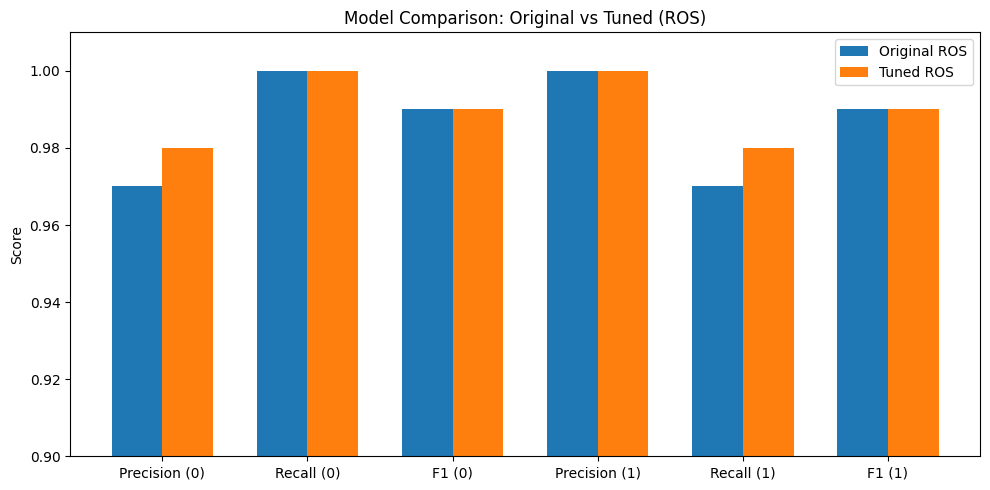

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
labels = ['Precision (0)', 'Recall (0)', 'F1 (0)', 'Precision (1)', 'Recall (1)', 'F1 (1)']
original = [0.97, 1.00, 0.99, 1.00, 0.97, 0.99]
tuned =    [0.98, 1.00, 0.99, 1.00, 0.98, 0.99]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, original, width, label='Original ROS')
rects2 = ax.bar(x + width/2, tuned, width, label='Tuned ROS')

ax.set_ylabel('Score')
ax.set_title('Model Comparison: Original vs Tuned (ROS)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.ylim(0.9, 1.01)

plt.tight_layout()
plt.show()


In this peculiar case, both models perform very well and the model tuning does not seem to improve the model all that much. However, in some case the difference can be meaningful. So it is a recomended practice to always explore this option.

In [ ]:
# Optional to save plot
plot_filename = 'model_comparison.png'
plt.savefig(plot_filename, dpi=300)

In [21]:
# Get the best tuned pipeline
clf_pipeline = grid_search.best_estimator_

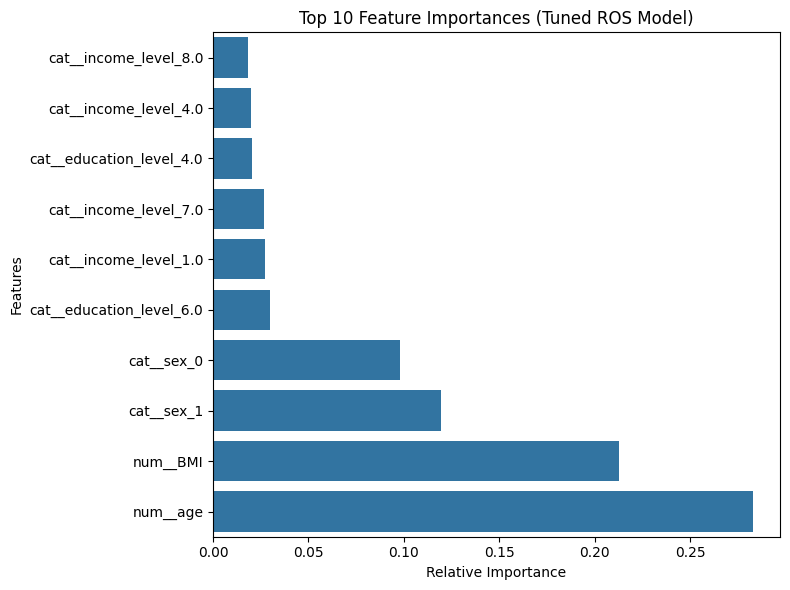

In [22]:
# Extract trained classifier and feature names
model = clf_pipeline.named_steps['clf']
feature_names = clf_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Plot feature importances
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10

plt.figure(figsize=(8, 6))
sns.barplot(x=importances[indices], y=feature_names[indices])
plt.title("Top 10 Feature Importances (Tuned ROS Model)")
plt.xlabel("Relative Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.savefig("importance_plots.png", dpi=300)
plt.show()


In [ ]:
#Download the saved image to your computer (optional)
files.download(plot_filename)

Feature importance = how much each variable helps the model split classes correctly. In this case we can aculay see that not all levels in a feature contibute equally to model perfomance.

You can now interogate subtle patterns (e.g., high income brackets vs. low, men vs women participants etc.).

Tasks:
 1. Discuss why age, BMI, education, or income might be ranked high.
 2.  Would these be your top predictors of diabetes? Why?

In [ ]:
# Install imbalanced-learn if missing
!pip install imbalanced-learn


Unfortunately, partial dependence plots (PDPs) do not work well for categorical features in Python. In this case, attempting to include variables like sex, income_level, or education_level results in errors due to how they are internally encoded. R currently handles PDPs for categorical variables more gracefully, and we may revisit this functionality after further troubleshooting.

An alternative to PDPs is SHAP (SHapley Additive exPlanations), which provides a unified measure of feature importance and individual effect sizes, even for categorical variables. SHAP values allow us to visualize both the magnitude and direction of each feature’s impact on predictions, offering a more flexible and interpretable approach to model explainability.

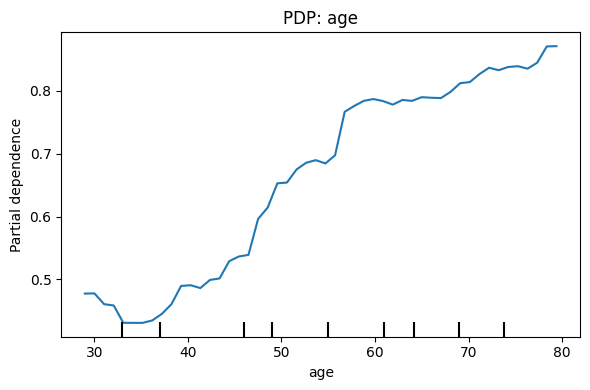

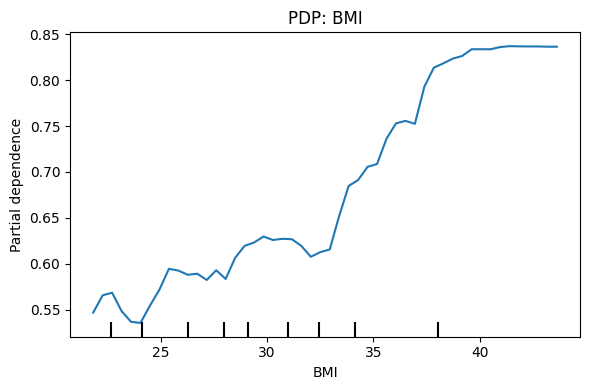

ValueError: cannot reshape array of size 1 into shape (2)

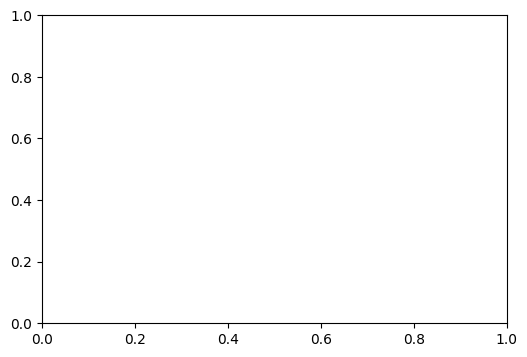

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

# Step 1: Identify columns
categorical_cols = ['sex', 'smoker', 'physical_activity', 'education_level', 'income_level']
numeric_cols = ['age', 'BMI']
all_features = categorical_cols + numeric_cols

# Subset the data
X_subset = X[all_features]
y_subset = y.copy()

# Step 2: Encode + scale via ColumnTransformer
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ("num", StandardScaler(), numeric_cols)
])

# Step 3: Wrap in pipeline
clf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Step 4: Resample and split
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_subset, y_subset)
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=42)

# Step 5: Fit model
clf_pipeline.fit(X_train, y_train)

# Step 6: Plot partial dependence (now works with pipeline!)
features_for_plot = ['age', 'BMI', 'sex', 'income_level', 'education_level', 'smoker']

for feat in features_for_plot:
    fig, ax = plt.subplots(figsize=(6, 4))
    PartialDependenceDisplay.from_estimator(
        clf_pipeline, X_test, [feat],
        grid_resolution=50, ax=ax
    )
    plt.title(f"PDP: {feat}")
    plt.tight_layout()
    plt.savefig("partial_dependence_plots.png", dpi=300)
    plt.show()


# Wrap-Up

1. What did we learn about imbalance?
2. Why isn’t accuracy enough?
3. Which method worked best for our case?
4. Which variable is most important in predicting risk of diabetes?

Challenge
* Compare the interpretatin to a different classifier (e.g., LogisticRegression).
* What happens when you increase the number of trees?




In [38]:
# Export the tuned model
import joblib
joblib.dump(model_ros_tuned, "rf_diabetes_model.pkl")
print("Model saved as rf_diabetes_model.pkl")


Model saved as rf_diabetes_model.pkl
